In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore


# Function to remove outliers using Z-score
def remove_outliers(df, sensor_columns, z_thresh=3):
    """
    Removes rows with outliers based on Z-scores for specified sensor columns.
    
    Parameters:
    df (DataFrame): The input DataFrame containing sensor data.
    sensor_columns (list): List of sensor columns to check for outliers.
    z_thresh (float): The Z-score threshold to consider as an outlier.
    
    Returns:
    DataFrame: DataFrame with outliers removed.
    """
    # Calculate Z-scores for the sensor data
    z_scores = np.abs(zscore(df[sensor_columns]))
    
    # Keep rows where all Z-scores are below the threshold
    df_clean = df[(z_scores < z_thresh).all(axis=1)]
    
    return df_clean

# Function to normalize the data
def normalize_data(df, sensor_columns):
    """
    Normalizes each feature (sensor column) using Z-score normalization.
    
    Parameters:
    df (DataFrame): The input DataFrame containing sensor data.
    sensor_columns (list): List of sensor columns to normalize.
    
    Returns:
    DataFrame: DataFrame with normalized sensor data.
    """
    # Normalize each sensor column (Z-score normalization: mean=0, std=1)
    df_normalized = df.copy()
    df_normalized[sensor_columns] = df[sensor_columns].apply(zscore)
    
    return df_normalized

# Load your datasets
data_23rd = pd.read_csv(r'C:/Users/aidan/codeprojects/ML/ArduinoWineSniffer/src/data_analysis_for_NN/cleaned_data23rd.csv')
data_30th = pd.read_csv(r'C:/Users/aidan/codeprojects/ML/ArduinoWineSniffer/src/data_analysis_for_NN/cleaned_data30th.csv')

# Drop unnecessary timestamp column
data_23rd.drop(columns=['yyyy-mm-dd timestamp'], inplace=True)
data_30th.drop(columns=['yyyy-mm-dd timestamp'], inplace=True)

# Add a 'Day' column to distinguish between datasets
data_23rd['Day'] = '23rd'
data_30th['Day'] = '30th'

# Define sensor columns for MQ and environmental sensors (adjust based on your dataset)
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
env_sensors = ["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]
sensor_columns = mq_sensors + env_sensors

# Remove outliers from each dataset before combining
data_23rd_clean = remove_outliers(data_23rd, sensor_columns)
data_30th_clean = remove_outliers(data_30th, sensor_columns)

# Combine cleaned datasets for processing
combined_data_clean = pd.concat([data_23rd_clean, data_30th_clean], ignore_index=True)

# Normalize the combined data
normalized_data_clean = normalize_data(combined_data_clean, sensor_columns)

# Filter for specific wine labels in the Target column
wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]
filtered_data_clean = normalized_data_clean[normalized_data_clean['Target'].str.contains('|'.join(wine_labels))]

# Separate features and target labels
features = filtered_data_clean.drop(columns=['Target', 'Day'])
target_labels = filtered_data_clean['Target']
day_labels = filtered_data_clean['Day']

# Print the cleaned and normalized filtered data
print(filtered_data_clean)


             MQ6       MQ5       MQ4       MQ7       MQ3       MQ8       MQ2  \
0       0.252074  0.208988  0.404367  1.116534 -4.058606  0.918414  6.512248   
1       0.241129  0.249921  0.404367  1.116534 -3.897032  0.918414  6.512248   
2       0.241129  0.290854  0.373649  1.055972 -4.220180  0.918414  6.512248   
3       0.219239  0.249921  0.435085  1.146815 -4.058606  0.918414  6.660430   
4       0.241129  0.249921  0.373649  1.055972 -4.058606  0.918414  6.512248   
...          ...       ...       ...       ...       ...       ...       ...   
119701 -1.356846 -0.814333 -1.192984 -0.700331  0.627045 -1.654797 -0.526383   
119702 -1.334956 -0.896198 -1.131547 -0.760893  0.950193 -1.674745 -0.600474   
119703 -1.356846 -0.814333 -1.162266 -0.760893  0.788619 -1.694692 -0.600474   
119704 -1.356846 -0.814333 -1.192984 -0.700331  0.788619 -1.674745 -0.526383   
119705 -1.356846 -0.814333 -1.192984 -0.700331  0.950193 -1.654797 -0.674565   

           MQ135       MQ9  BMPTemperat

In [27]:
import os
import pandas as pd

input_folder = r"C:/Users/aidan/codeprojects/ML/ArduinoWineSniffer/ML/WineCSVs/AllWines"  # Path to the folder containing CSV files
output_file = "data_analysis_for_NN.csv"  # Path where cleaned data will be saved

RawWineData = pd.DataFrame()
total_rows_before = 0  # Variable to count total rows before cleaning
total_rows_after = 0  # Variable to count total rows after cleaning

# Function to remove rows that contain the substring '_A' in any columns except the last one
def remove_invalid_rows(data):
    last_column = data.columns[-1]
    non_last_columns = data.columns[:-1]

    mask = data[non_last_columns].apply(
        lambda row: ~row.astype(str).str.contains("_A").any(), axis=1
    )
    
    return data[mask]

# Function to remove outliers using IQR
def remove_outliers_iqr(data):
    # Select numeric columns
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
    
    # Calculate IQR for each numeric column and filter out outliers
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    
    return data

# Loop through all CSV files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):
        print(f"Processing file: {filename}")
        file_path = os.path.join(input_folder, filename)
        df = pd.read_csv(file_path)

        # Count rows before filtering
        rows_before = len(df)
        total_rows_before += rows_before
        
        # Remove invalid rows
        df_cleaned = remove_invalid_rows(df)

        # Count rows after invalid row removal
        rows_after_invalid_removal = len(df_cleaned)

        # Remove outliers using IQR
        df_filtered = remove_outliers_iqr(df_cleaned)

        # Count rows after outlier removal
        rows_after_outlier_removal = len(df_filtered)
        total_rows_after += rows_after_outlier_removal

        # Append the cleaned data to the final dataframe
        RawWineData = pd.concat([RawWineData, df_filtered], ignore_index=True)

        # Print row counts for the current file
        print(f"Rows before cleaning: {rows_before}, Rows after invalid row removal: {rows_after_invalid_removal}, Rows after outlier removal: {rows_after_outlier_removal}")

# Save the combined DataFrame to a new CSV file
RawWineData.to_csv(output_file, index=False)

# Print final statistics
print(f"Data compiling complete. Total rows before cleaning: {total_rows_before}, Total rows after cleaning: {total_rows_after}")
print(f"Combined data saved to: {output_file}")


Processing file: BlackTie2309(25degEnvTemp).csv
Rows before cleaning: 577, Rows after invalid row removal: 576, Rows after outlier removal: 434
Processing file: BlackTie2509(20degEnvTemp).csv
Rows before cleaning: 566, Rows after invalid row removal: 563, Rows after outlier removal: 558
Processing file: BlackTie3009(20degEnvTemp).csv
Rows before cleaning: 10242, Rows after invalid row removal: 10242, Rows after outlier removal: 6612
Processing file: BlackTieR2_3009(20degEnvTemp).csv
Rows before cleaning: 16332, Rows after invalid row removal: 16332, Rows after outlier removal: 8537
Processing file: Moscato2309(25degEnvTemp).csv
Rows before cleaning: 568, Rows after invalid row removal: 567, Rows after outlier removal: 490
Processing file: Moscato2509(20degEnvTemp).csv
Rows before cleaning: 580, Rows after invalid row removal: 577, Rows after outlier removal: 571
Processing file: Moscato3009(20degEnvTemp).csv
Rows before cleaning: 10624, Rows after invalid row removal: 10624, Rows after

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Separate MQ sensors and target labels
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
sensor_data = filtered_data[mq_sensors]
target_labels = filtered_data['Target']
day_labels = filtered_data['Day']

# Perform PCA to reduce to two principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sensor_data)

# Create a new DataFrame with the PCA results, wine labels, and day labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Target'] = target_labels.values
pca_df['Day'] = day_labels.values

# Define color map for each wine label
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Plot PCA results with improved visibility
plt.figure(figsize=(10, 7))
marker_size = 200  # Define a large marker size

# Store average distances between 23rd and 30th day points for each wine
avg_distances = {}

# Loop through each wine and plot
for wine in wine_labels:
    # Plot 'X' for the 23rd
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    plt.scatter(wine_data_23rd['PC1'], wine_data_23rd['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot 'O' for the 30th
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    plt.scatter(wine_data_30th['PC1'], wine_data_30th['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                s=marker_size, alpha=0.8)
    
    # Calculate the average distance between the points from 23rd and 30th
    if len(wine_data_23rd) > 0 and len(wine_data_30th) > 0:
        distances = cdist(wine_data_23rd[['PC1', 'PC2']], wine_data_30th[['PC1', 'PC2']])
        avg_distance = np.mean(np.min(distances, axis=1))  # Take the minimum distance for each point
        avg_distances[wine] = avg_distance

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MQ Sensor Data (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()

# Print the average distances between the 23rd and 30th for each wine
print("Average distances between 'X's (23rd) and 'O's (30th) for each wine:")
for wine, distance in avg_distances.items():
    print(f"{wine}: {distance:.2f}")


NameError: name 'filtered_data' is not defined

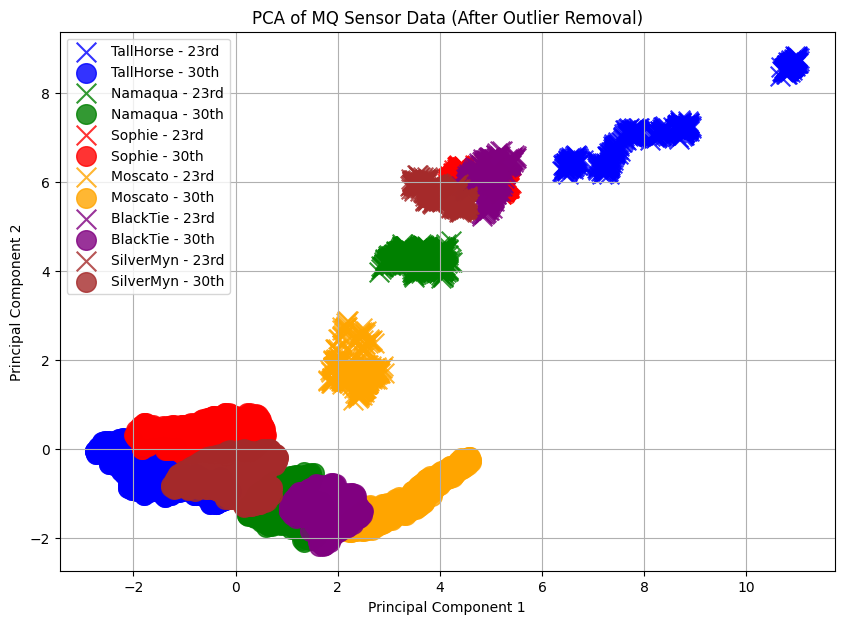

Average distances between 'X's (23rd) and 'O's (30th) for each wine:
TallHorse: 11.85
Namaqua: 5.27
Sophie: 6.79
Moscato: 2.76
BlackTie: 7.44
SilverMyn: 6.64


In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

# Separate MQ sensors and target labels
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
sensor_data = filtered_data_clean[mq_sensors]
target_labels = filtered_data_clean['Target']
day_labels = filtered_data_clean['Day']

# Perform PCA to reduce to two principal components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sensor_data)

# Create a new DataFrame with the PCA results, wine labels, and day labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Target'] = target_labels.values
pca_df['Day'] = day_labels.values

# Define color map for each wine label
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Plot PCA results with improved visibility
plt.figure(figsize=(10, 7))
marker_size = 200  # Define a large marker size

# Store average distances between 23rd and 30th day points for each wine
avg_distances = {}

# Loop through each wine and plot
for wine in wine_labels:
    # Plot 'X' for the 23rd
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    plt.scatter(wine_data_23rd['PC1'], wine_data_23rd['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot 'O' for the 30th
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    plt.scatter(wine_data_30th['PC1'], wine_data_30th['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                s=marker_size, alpha=0.8)
    
    # Calculate the average distance between the points from 23rd and 30th
    if len(wine_data_23rd) > 0 and len(wine_data_30th) > 0:
        distances = cdist(wine_data_23rd[['PC1', 'PC2']], wine_data_30th[['PC1', 'PC2']])
        avg_distance = np.mean(np.min(distances, axis=1))  # Take the minimum distance for each point
        avg_distances[wine] = avg_distance

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MQ Sensor Data (After Outlier Removal)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()

# Print the average distances between the 23rd and 30th for each wine
print("Average distances between 'X's (23rd) and 'O's (30th) for each wine:")
for wine, distance in avg_distances.items():
    print(f"{wine}: {distance:.2f}")


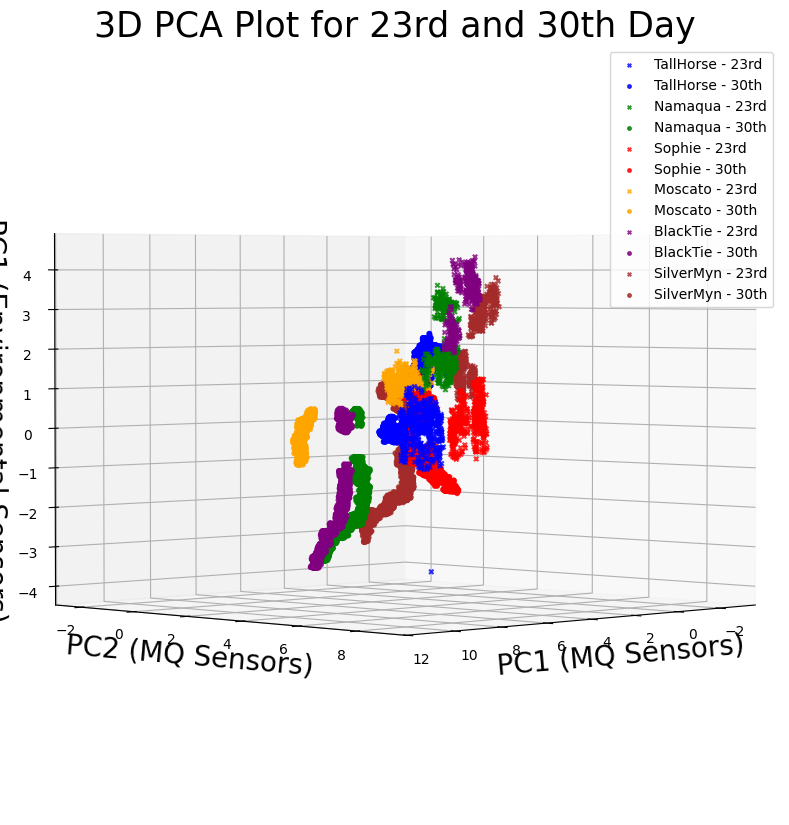

In [12]:
# Set up a 3D plot with a wider figure size
fig = plt.figure(figsize=(15, 10))  # Increase width to 15
ax = fig.add_subplot(111, projection='3d')

# Marker size for visibility
marker_size = 10

# Define color map for each wine label
color_map = {
    "TallHorse": 'blue',
    "Namaqua": 'green',
    "Sophie": 'red',
    "Moscato": 'orange',
    "BlackTie": 'purple',
    "SilverMyn": 'brown'
}

# Loop through each wine and plot for both days
for wine in color_map.keys():
    # Plot for the 23rd day
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    ax.scatter(wine_data_23rd['PC1_MQ'], wine_data_23rd['PC2_MQ'], wine_data_23rd['PC1_Env'],
               color=color_map[wine], marker='x', label=f'{wine} - 23rd', s=marker_size, alpha=0.8)
    
    # Plot for the 30th day
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    ax.scatter(wine_data_30th['PC1_MQ'], wine_data_30th['PC2_MQ'], wine_data_30th['PC1_Env'],
               color=color_map[wine], marker='o', label=f'{wine} - 30th', s=marker_size, alpha=0.8)

# Add axis labels with adjusted font sizes
ax.set_xlabel('PC1 (MQ Sensors)', fontsize=14)
ax.set_ylabel('PC2 (MQ Sensors)', fontsize=14)
ax.set_zlabel('PC1 (Environmental Sensors)', fontsize=14)

# Add a title with adjusted font size
plt.title('3D PCA Plot for 23rd and 30th Day', fontsize=25)

# Adjust the layout to shift the plot slightly to the right
plt.subplots_adjust(left=0.1, right=0.9)  # Increase 'left' to push the plot to the right

# Optionally adjust the view angle for better visibility
ax.view_init(elev=2, azim=45)  # Adjust these values for a better view

# Add grid
ax.grid(True)

# Add legend
plt.legend(loc='best', fontsize=10, markerscale=0.8)

# Show the plot
plt.show()


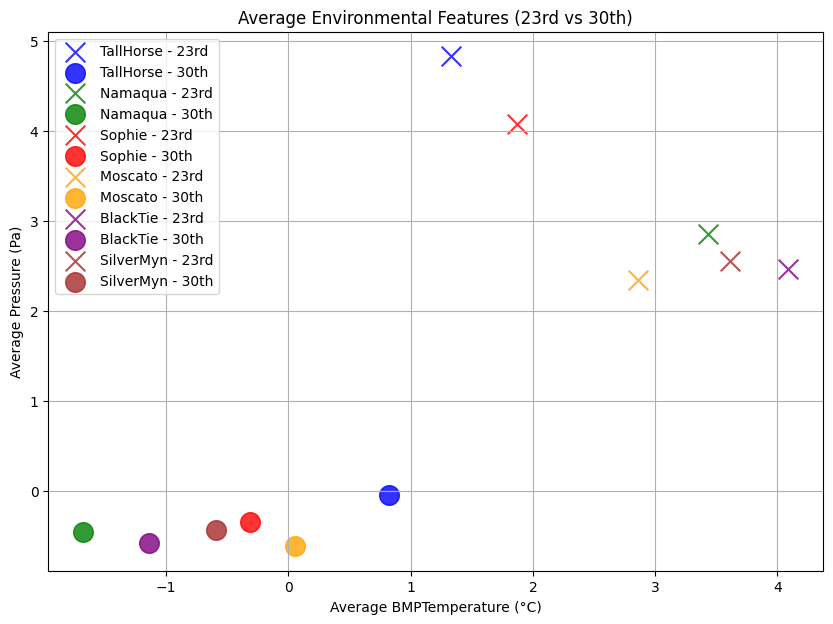

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Separate the environmental features and target labels
env_features = ["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]
env_data = filtered_data_clean[env_features]
target_labels = filtered_data_clean['Target']
day_labels = filtered_data_clean['Day']


# Calculate average environmental features for each wine on the 23rd and 30th
average_env_23rd = filtered_data_clean[filtered_data_clean['Day'] == '23rd'].groupby('Target')[env_features].mean()
average_env_30th = filtered_data_clean[filtered_data_clean['Day'] == '30th'].groupby('Target')[env_features].mean()

# Create a new figure for the plot
plt.figure(figsize=(10, 7))
marker_size = 200

# Loop through each wine and plot the average environmental feature differences between the 23rd and 30th
for wine in wine_labels:
    if wine in average_env_23rd.index and wine in average_env_30th.index:
        # Extract the average environmental features for the 23rd and 30th
        avg_env_23rd = average_env_23rd.loc[wine]
        avg_env_30th = average_env_30th.loc[wine]
        
        # Plot 'X' for the 23rd
        plt.scatter(avg_env_23rd['BMPTemperature'], avg_env_23rd['Pressure(Pa)'], 
                    color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                    s=marker_size, alpha=0.8)
        
        # Plot 'O' for the 30th
        plt.scatter(avg_env_30th['BMPTemperature'], avg_env_30th['Pressure(Pa)'], 
                    color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                    s=marker_size, alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Average BMPTemperature (°C)')
plt.ylabel('Average Pressure (Pa)')
plt.title('Average Environmental Features (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()


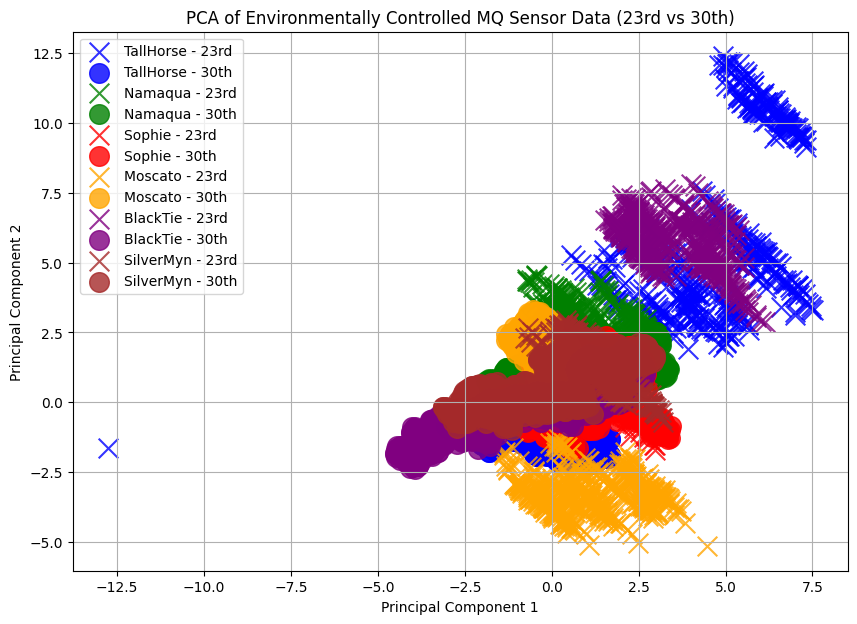

Average Euclidean Distance between the 23rd and 30th for each wine:
TallHorse: 8.4470
Namaqua: 2.2435
Sophie: 1.7269
Moscato: 5.1500
BlackTie: 7.0154
SilverMyn: 2.0701


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances

# Separate MQ sensor and environmental features
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
env_features = ["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]

# Initialize a dictionary to store the "cleaned" MQ sensor data
cleaned_mq_data = pd.DataFrame()
env_regression_mq_data = cleaned_mq_data
# Iterate over each MQ sensor and fit a linear regression model using environmental features as predictors
for sensor in mq_sensors:
    # Define the independent variables (env features) and the dependent variable (MQ sensor)
    X = combined_data_clean[env_features]
    y = combined_data_clean[sensor]
    
    # Fit a linear regression model
    reg = LinearRegression()
    reg.fit(X, y)
    
    # Predict the MQ sensor values based on environmental features
    y_pred = reg.predict(X)
    
    # Subtract the predicted values from the actual MQ sensor values to get the residuals
    # These residuals are the "cleaned" sensor readings with environmental effects removed
    residuals = y - y_pred
    
    # Store the residuals in the cleaned data
    env_regression_mq_data[sensor] = residuals

# Add back the target labels and day labels to the cleaned MQ sensor data
env_regression_mq_data['Target'] = combined_data_clean['Target'].values
env_regression_mq_data['Day'] = combined_data_clean['Day'].values

# Now, perform PCA on the cleaned MQ sensor data
pca = PCA(n_components=2)
scaled_data = StandardScaler().fit_transform(env_regression_mq_data[mq_sensors])  # Scaling the data
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Target'] = env_regression_mq_data['Target']
pca_df['Day'] = env_regression_mq_data['Day']

plt.figure(figsize=(10, 7))
marker_size = 200



# Store Euclidean distances for each wine
wine_distances = {}

# Loop through each wine and plot the cleaned data for the 23rd and 30th
for wine in wine_labels:
    # Get PCA data for the 23rd and 30th for the current wine
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    
    # Plot 'X' for the 23rd
    plt.scatter(wine_data_23rd['PC1'], wine_data_23rd['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot 'O' for the 30th
    plt.scatter(wine_data_30th['PC1'], wine_data_30th['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                s=marker_size, alpha=0.8)
    
    # Calculate Euclidean distance between the 23rd and 30th points
    if len(wine_data_23rd) > 0 and len(wine_data_30th) > 0:
        # Compute pairwise Euclidean distances
        distances = euclidean_distances(wine_data_23rd[['PC1', 'PC2']].values,
                                        wine_data_30th[['PC1', 'PC2']].values)
        
        # Calculate average Euclidean distance for the wine
        avg_distance = np.mean(distances)
        wine_distances[wine] = avg_distance

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Environmentally Controlled MQ Sensor Data (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()

# Print Euclidean distances between the 23rd and 30th for each wine
print("Average Euclidean Distance between the 23rd and 30th for each wine:")
for wine, distance in wine_distances.items():
    print(f"{wine}: {distance:.4f}")

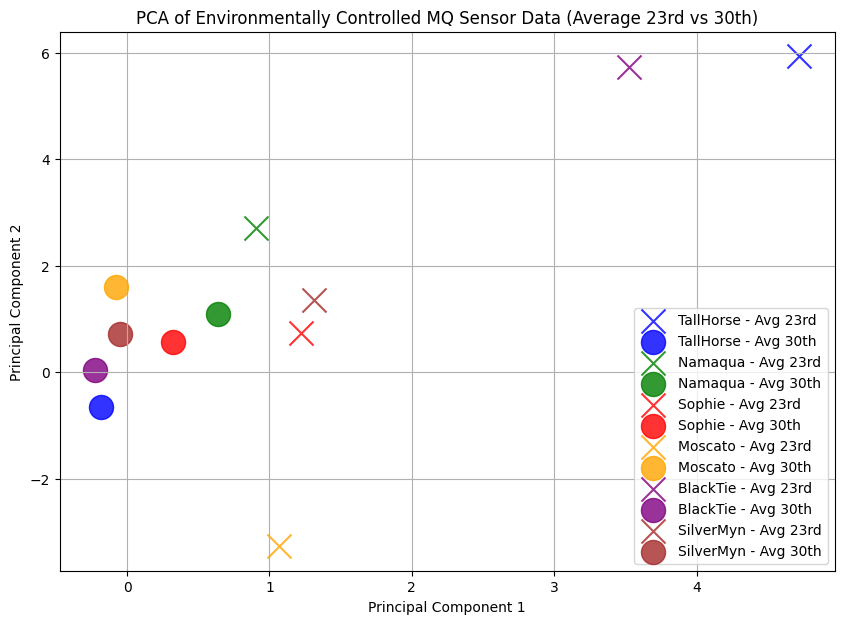

In [7]:
# Create a new plot to show the average X and O for each wine
plt.figure(figsize=(10, 7))
marker_size = 300  # Larger marker size for the averages

# Loop through each wine and calculate the average PC1 and PC2 for the 23rd and 30th
for wine in wine_labels:
    # Get PCA data for the 23rd and 30th for the current wine
    wine_data_23rd = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '23rd')]
    wine_data_30th = pca_df[(pca_df['Target'] == wine) & (pca_df['Day'] == '30th')]
    
    # Calculate the average PC1 and PC2 for the 23rd
    avg_23rd = wine_data_23rd[['PC1', 'PC2']].mean()
    
    # Calculate the average PC1 and PC2 for the 30th
    avg_30th = wine_data_30th[['PC1', 'PC2']].mean()
    
    # Plot the average point for the 23rd (X)
    plt.scatter(avg_23rd['PC1'], avg_23rd['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - Avg 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot the average point for the 30th (O)
    plt.scatter(avg_30th['PC1'], avg_30th['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - Avg 30th', 
                s=marker_size, alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Environmentally Controlled MQ Sensor Data (Average 23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()


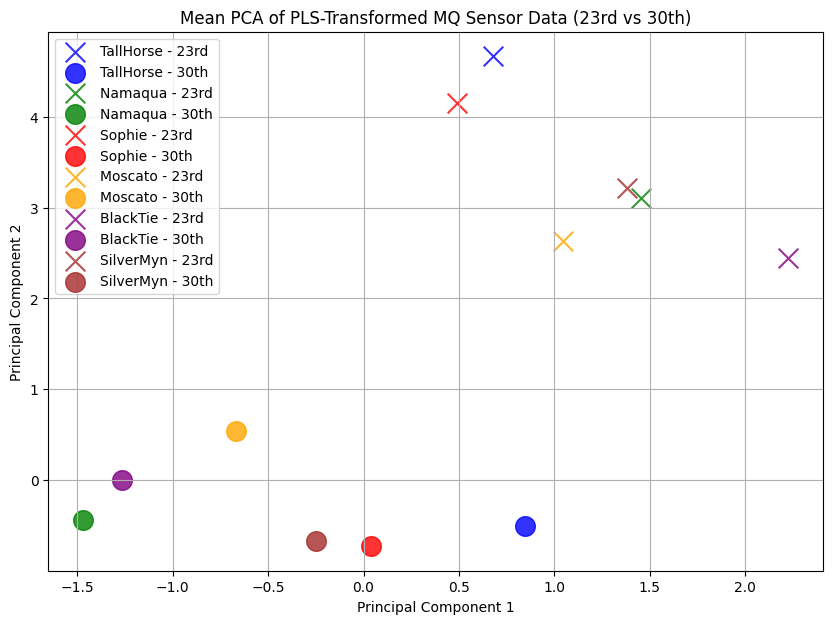

Average Euclidean Distance between the mean PCA points for the 23rd and 30th for each wine:
TallHorse: 5.1743
Namaqua: 4.5871
Sophie: 4.8953
Moscato: 2.6995
BlackTie: 4.2627
SilverMyn: 4.2128


In [31]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances

# Scale the environmental and sensor data
scaler_env = StandardScaler()
scaler_mq = StandardScaler()

X_env = scaler_env.fit_transform(combined_data_clean[env_features])
Y_mq = scaler_mq.fit_transform(combined_data_clean[mq_sensors])

# Apply Partial Least Squares (PLS) regression
pls = PLSRegression(n_components=2)  # Using 2 components for dimensionality reduction
pls.fit(X_env, Y_mq)

# Get the transformed MQ sensor data after removing environmental influence
mq_transformed = pls.transform(X_env)

# Create a DataFrame with the "cleaned" MQ data from PLS regression
pls_mq_df = pd.DataFrame(mq_transformed, columns=["PLS1", "PLS2"])
pls_mq_df['Target'] = combined_data_clean['Target'].values
pls_mq_df['Day'] = combined_data_clean['Day'].values

# Apply PCA on the PLS-transformed MQ sensor data
pca_pls = PCA(n_components=2)
scaled_pls_mq = StandardScaler().fit_transform(pls_mq_df[['PLS1', 'PLS2']])  # Scaling the data
pca_result_pls = pca_pls.fit_transform(scaled_pls_mq)

# Create a DataFrame with the PCA results after PLS
pca_df_pls = pd.DataFrame(data=pca_result_pls, columns=['PC1', 'PC2'])
pca_df_pls['Target'] = pls_mq_df['Target']
pca_df_pls['Day'] = pls_mq_df['Day']

# Calculate mean PCA values for each wine and day
mean_pca_df = pca_df_pls.groupby(['Target', 'Day'])[['PC1', 'PC2']].mean().reset_index()

plt.figure(figsize=(10, 7))
marker_size = 200

# Loop through each wine and plot the mean transformed data for the 23rd and 30th
for wine in wine_labels:
    # Get mean PCA data for the 23rd and 30th for the current wine
    mean_wine_data = mean_pca_df[mean_pca_df['Target'] == wine]
    
    # Plot mean 'X' for the 23rd
    plt.scatter(mean_wine_data[mean_wine_data['Day'] == '23rd']['PC1'],
                mean_wine_data[mean_wine_data['Day'] == '23rd']['PC2'], 
                color=color_map[wine], marker='x', label=f'{wine} - 23rd', 
                s=marker_size, alpha=0.8)
    
    # Plot mean 'O' for the 30th
    plt.scatter(mean_wine_data[mean_wine_data['Day'] == '30th']['PC1'],
                mean_wine_data[mean_wine_data['Day'] == '30th']['PC2'], 
                color=color_map[wine], marker='o', label=f'{wine} - 30th', 
                s=marker_size, alpha=0.8)

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Mean PCA of PLS-Transformed MQ Sensor Data (23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()

# Calculate and print Euclidean distances between the mean PCA points for each wine
mean_wine_distances = {}
for wine in wine_labels:
    mean_data = mean_pca_df[mean_pca_df['Target'] == wine]
    if len(mean_data) == 2:  # Check if both days are present
        distance = euclidean_distances(mean_data[mean_data['Day'] == '23rd'][['PC1', 'PC2']].values,
                                        mean_data[mean_data['Day'] == '30th'][['PC1', 'PC2']].values)
        mean_wine_distances[wine] = distance[0][0]

# Print mean Euclidean distances between the 23rd and 30th for each wine
print("Average Euclidean Distance between the mean PCA points for the 23rd and 30th for each wine:")
for wine, distance in mean_wine_distances.items():
    print(f"{wine}: {distance:.4f}")


In [33]:
# Calculate and print the closest wine shape for each wine, including the day for both wines
closest_neighbors = {}

# Loop through each wine and find the closest other wine for both 23rd and 30th
for wine in wine_labels:
    closest_neighbors[wine] = {}
    for day in ['23rd', '30th']:
        # Get the PCA values for the current wine on the current day
        wine_data = mean_pca_df[(mean_pca_df['Target'] == wine) & (mean_pca_df['Day'] == day)][['PC1', 'PC2']].values
        
        # Initialize variables to track the closest wine and minimum distance
        min_distance = float('inf')
        closest_wine = None
        closest_day = None
        
        # Loop through all other wines to find the closest one
        for other_wine in wine_labels:
            if wine != other_wine:
                for other_day in ['23rd', '30th']:  # Compare across both days for the other wines
                    # Get the PCA values for the other wine on the current day
                    other_wine_data = mean_pca_df[(mean_pca_df['Target'] == other_wine) & (mean_pca_df['Day'] == other_day)][['PC1', 'PC2']].values
                    if len(other_wine_data) > 0:  # Ensure data exists for this other wine on the current day
                        # Calculate the Euclidean distance between the wines
                        distance = euclidean_distances(wine_data, other_wine_data)[0][0]
                        if distance < min_distance:
                            min_distance = distance
                            closest_wine = other_wine
                            closest_day = other_day
        
        # Store the closest wine, closest day, and the minimum distance for this wine and day
        closest_neighbors[wine][day] = (closest_wine, closest_day, min_distance)

# Print the closest neighbor and distance for each wine and day, including the day of both wines
print("\nClosest neighbors for each wine and day:")
for wine, neighbors in closest_neighbors.items():
    for day, (closest_wine, closest_day, distance) in neighbors.items():
        print(f"{wine} ({day}): Closest to {closest_wine} ({closest_day}) with a distance of {distance:.4f}")



Closest neighbors for each wine and day:
TallHorse (23rd): Closest to Sophie (23rd) with a distance of 0.5474
TallHorse (30th): Closest to Sophie (30th) with a distance of 0.8374
Namaqua (23rd): Closest to SilverMyn (23rd) with a distance of 0.1364
Namaqua (30th): Closest to BlackTie (30th) with a distance of 0.4820
Sophie (23rd): Closest to TallHorse (23rd) with a distance of 0.5474
Sophie (30th): Closest to SilverMyn (30th) with a distance of 0.2921
Moscato (23rd): Closest to Namaqua (23rd) with a distance of 0.6257
Moscato (30th): Closest to BlackTie (30th) with a distance of 0.8051
BlackTie (23rd): Closest to Namaqua (23rd) with a distance of 1.0077
BlackTie (30th): Closest to Namaqua (30th) with a distance of 0.4820
SilverMyn (23rd): Closest to Namaqua (23rd) with a distance of 0.1364
SilverMyn (30th): Closest to Sophie (30th) with a distance of 0.2921


# Running different models to alleviate environmental influence, and returning results

Processing model: Ridge
Processing model: Lasso
Processing model: ElasticNet
Processing model: RandomForest
Processing model: XGBoost
Processing model: MLP


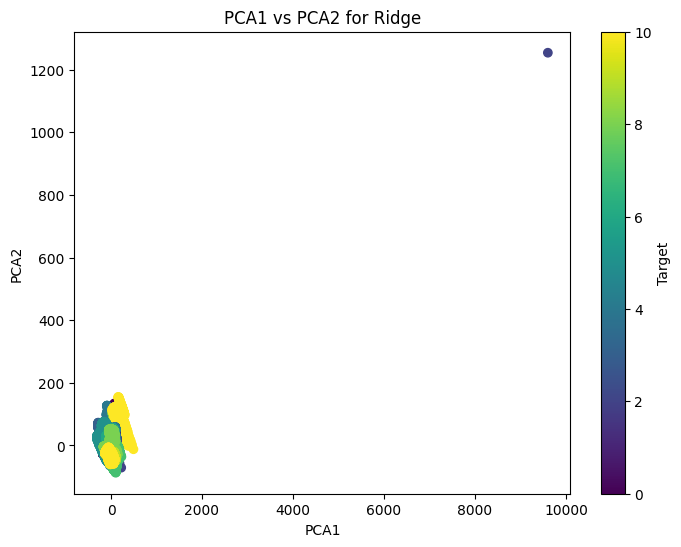

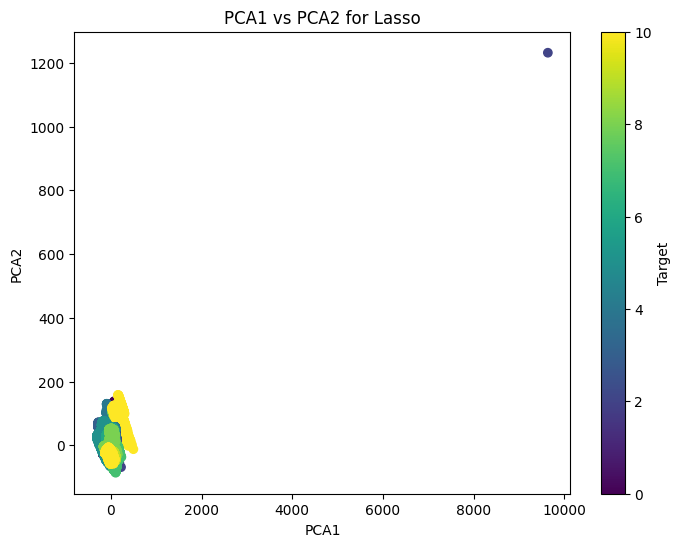

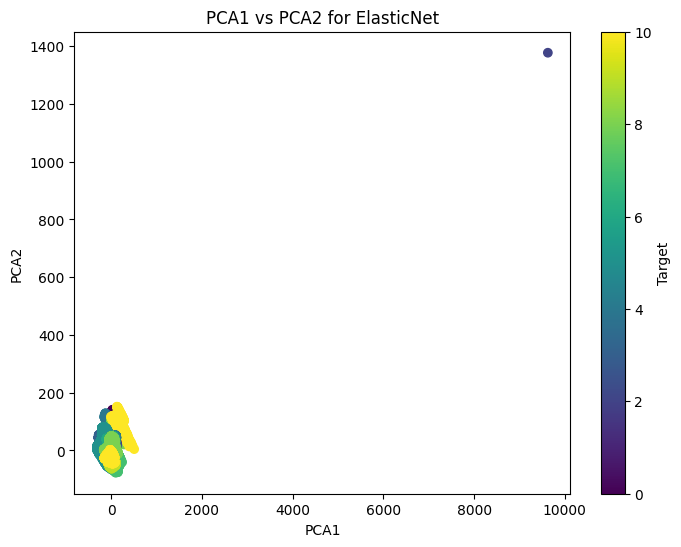

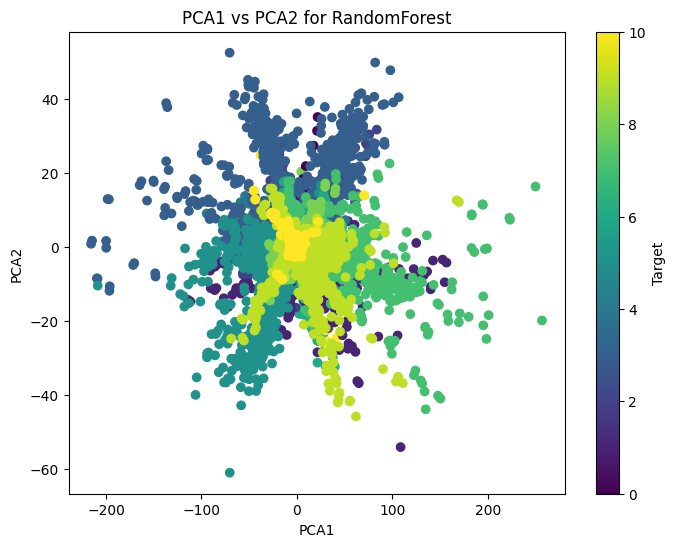

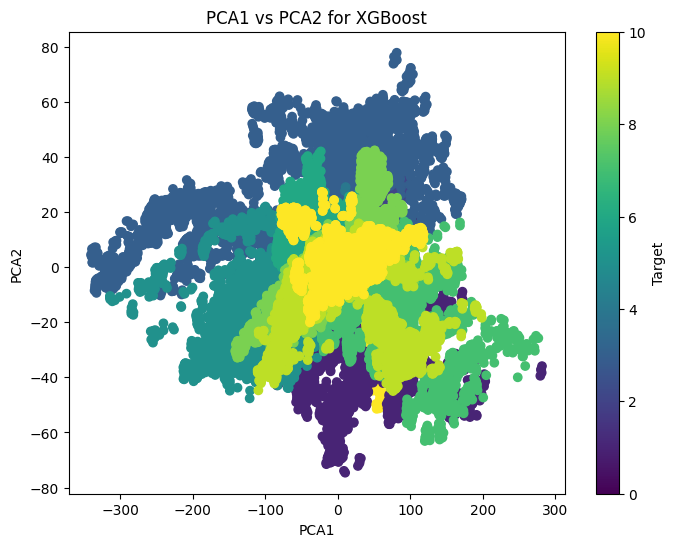

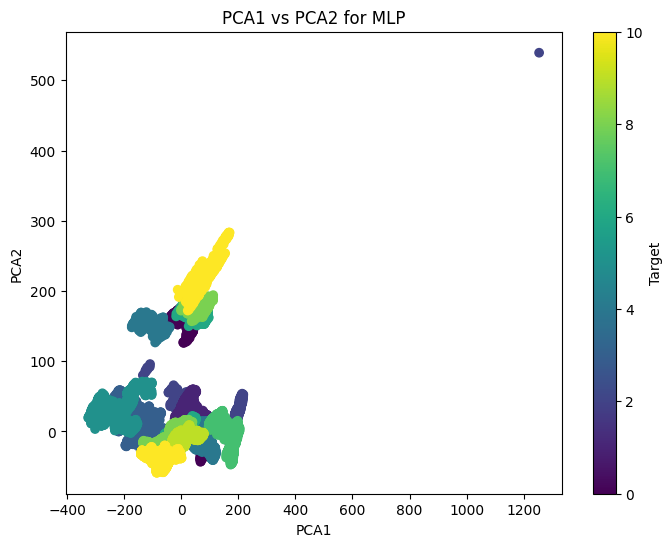

Ridge PCA1 average: 1.1580572051414834e-16, PCA2 average: 1.6212800871980767e-15
Lasso PCA1 average: -4.6322288205659335e-16, PCA2 average: 8.106400435990383e-16
ElasticNet PCA1 average: 1.1580572051414834e-15, PCA2 average: 1.3896686461697801e-15
RandomForest PCA1 average: -1.3751929311055114e-16, PCA2 average: -2.3975403075194773e-17
XGBoost PCA1 average: 2.026600108997596e-15, PCA2 average: 8.685429038561126e-17
MLP PCA1 average: 1.2043794933471427e-14, PCA2 average: -4.632228820565934e-15
Euclidean distances between model residuals in PCA space:
                     Ridge         Lasso    ElasticNet  RandomForest  \
Ridge         0.000000e+00  9.961985e-16  1.067676e-15  1.664644e-15   
Lasso         9.961985e-16  0.000000e+00  1.721576e-15  8.959162e-16   
ElasticNet    1.067676e-15  1.721576e-15  0.000000e+00  1.917527e-15   
RandomForest  1.664644e-15  8.959162e-16  1.917527e-15  0.000000e+00   
XGBoost       2.450632e-15  2.592891e-15  1.565788e-15  2.166955e-15   
MLP         

In [7]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import LabelEncoder

# Assuming mq_sensors and combined_data_clean are defined elsewhere
env_features = ["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]

# Define models to evaluate
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'MLP': MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
}

# Initialize a dictionary to store residual data for each model
residuals_dict = {model_name: pd.DataFrame() for model_name in models.keys()}

# Iterate through each model and each sensor
for model_name, model in models.items():
    print(f"Processing model: {model_name}")
    for sensor in mq_sensors:
        X = combined_data_clean[env_features]
        y = combined_data_clean[sensor]
        
        # Fit the model
        model.fit(X, y)
        
        # Predict and calculate residuals
        y_pred = model.predict(X)
        residuals = y - y_pred
        
        # Store residuals
        residuals_dict[model_name][sensor] = residuals
    
    # Add back the target and day labels
    residuals_dict[model_name]['Target'] = combined_data_clean['Target'].values
    residuals_dict[model_name]['Day'] = combined_data_clean['Day'].values

# Encode 'Target' labels as numeric values
label_encoder = LabelEncoder()
combined_data_clean['Target_encoded'] = label_encoder.fit_transform(combined_data_clean['Target'])

# Example: Perform PCA on residuals for each model and plot PCA1 vs PCA2
pca_results = {}
for model_name, residuals in residuals_dict.items():
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(residuals[mq_sensors])
    
    pca_results[model_name] = pca_result
    # Plot PCA1 vs PCA2
    plt.figure(figsize=(8, 6))
    
    # Use the encoded 'Target' for color mapping
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=combined_data_clean['Target_encoded'], cmap='viridis')
    plt.colorbar(label='Target')
    plt.title(f'PCA1 vs PCA2 for {model_name}')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.show()

# Calculate PCA1 and PCA2 averages for each model
pca_averages = {}
for model_name, pca_result in pca_results.items():
    pca1_avg = np.mean(pca_result[:, 0])
    pca2_avg = np.mean(pca_result[:, 1])
    pca_averages[model_name] = (pca1_avg, pca2_avg)
    print(f"{model_name} PCA1 average: {pca1_avg}, PCA2 average: {pca2_avg}")

# Compute Euclidean distance between residuals of models
distances = pairwise_distances(
    np.array([pca_averages[model_name] for model_name in models.keys()])
)

# Print Euclidean distances between models
print("Euclidean distances between model residuals in PCA space:")
distance_df = pd.DataFrame(distances, index=models.keys(), columns=models.keys())
print(distance_df)

# Find the closest neighbors for each model
for i, model_name in enumerate(models.keys()):
    closest_model_idx = np.argsort(distances[i])[1]  # 1st is self, so we take the 2nd
    closest_model = list(models.keys())[closest_model_idx]
    print(f"{model_name}'s closest model is {closest_model} with a distance of {distances[i][closest_model_idx]:.4f}")


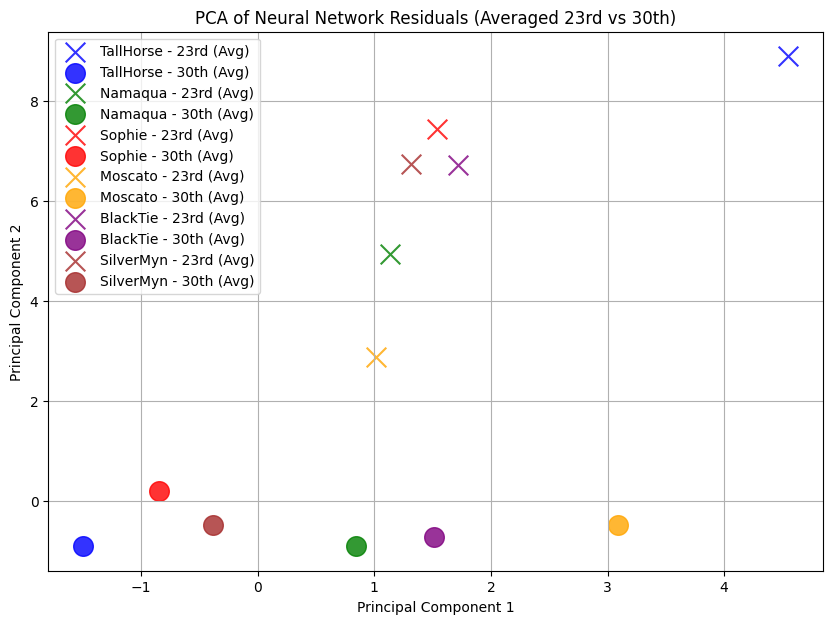

Average Euclidean Distance between the 23rd and 30th for each target:
TallHorse: 11.5114
Namaqua: 5.8437
Sophie: 7.6346
Moscato: 3.9430
BlackTie: 7.4513
SilverMyn: 7.4155


In [11]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming mq_sensors and env_features are defined as:
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
env_features = ["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]

# Initialize MLP model
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)

# Initialize a dictionary to store residual data
residuals_dict = pd.DataFrame()

# Iterate over each MQ sensor
for sensor in mq_sensors:
    X = combined_data_clean[env_features]
    y = combined_data_clean[sensor]
    
    # Fit MLP model
    mlp.fit(X, y)
    
    # Predict and calculate residuals
    y_pred = mlp.predict(X)
    residuals = y - y_pred
    
    # Store residuals
    residuals_dict[sensor] = residuals

# Add back target and day labels
residuals_dict['Target'] = combined_data_clean['Target'].values
residuals_dict['Day'] = combined_data_clean['Day'].values

# Perform PCA on the residuals
pca = PCA(n_components=2)
scaled_residuals = StandardScaler().fit_transform(residuals_dict[mq_sensors])  # Scale the residuals
pca_result = pca.fit_transform(scaled_residuals)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Target'] = residuals_dict['Target']
pca_df['Day'] = residuals_dict['Day']


plt.figure(figsize=(10, 7))
marker_size = 200

# Store Euclidean distances for each target
target_distances = {}

# To store average positions for each target
average_positions = {}

# Loop through each target and plot the residuals from the 23rd and 30th day
for target in color_map.keys():
    # Get PCA data for the 23rd and 30th for the current target
    target_data_23rd = pca_df[(pca_df['Target'] == target) & (pca_df['Day'] == '23rd')]
    target_data_30th = pca_df[(pca_df['Target'] == target) & (pca_df['Day'] == '30th')]
    
    # Calculate average positions for 23rd and 30th days
    avg_23rd = target_data_23rd[['PC1', 'PC2']].mean()
    avg_30th = target_data_30th[['PC1', 'PC2']].mean()
    
    # Store average positions for later
    average_positions[target] = {'23rd': avg_23rd, '30th': avg_30th}
    
    # Plot average 'X' for the 23rd day
    plt.scatter(avg_23rd['PC1'], avg_23rd['PC2'], 
                color=color_map[target], marker='x', label=f'{target} - 23rd (Avg)', 
                s=marker_size, alpha=0.8)
    
    # Plot average 'O' for the 30th day
    plt.scatter(avg_30th['PC1'], avg_30th['PC2'], 
                color=color_map[target], marker='o', label=f'{target} - 30th (Avg)', 
                s=marker_size, alpha=0.8)
    
    # Calculate Euclidean distance between the 23rd and 30th average positions
    if not avg_23rd.isnull().any() and not avg_30th.isnull().any():
        distance = np.linalg.norm(avg_23rd - avg_30th)
        target_distances[target] = distance

# Add labels, title, and legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Neural Network Residuals (Averaged 23rd vs 30th)')
plt.legend(loc='best')
plt.grid(True)

# Show plot
plt.show()

# Print Euclidean distances between the 23rd and 30th for each target
print("Average Euclidean Distance between the 23rd and 30th for each target:")
for target, distance in target_distances.items():
    print(f"{target}: {distance:.4f}")


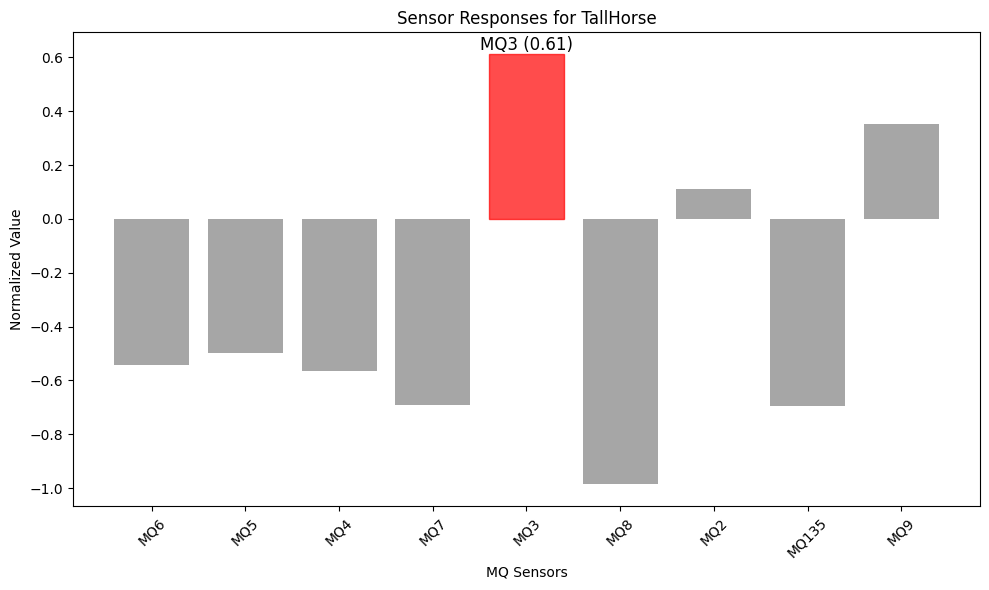

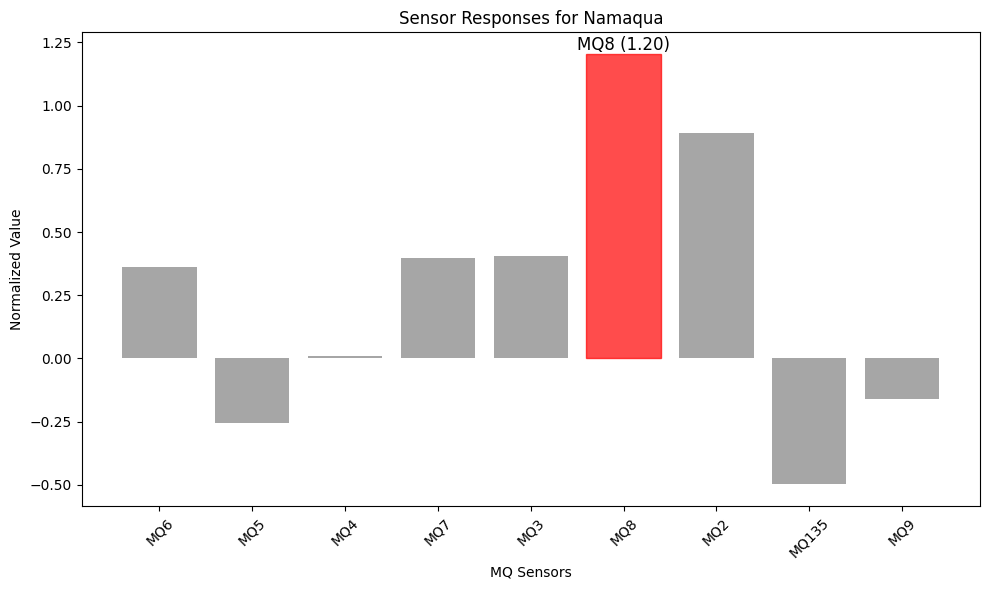

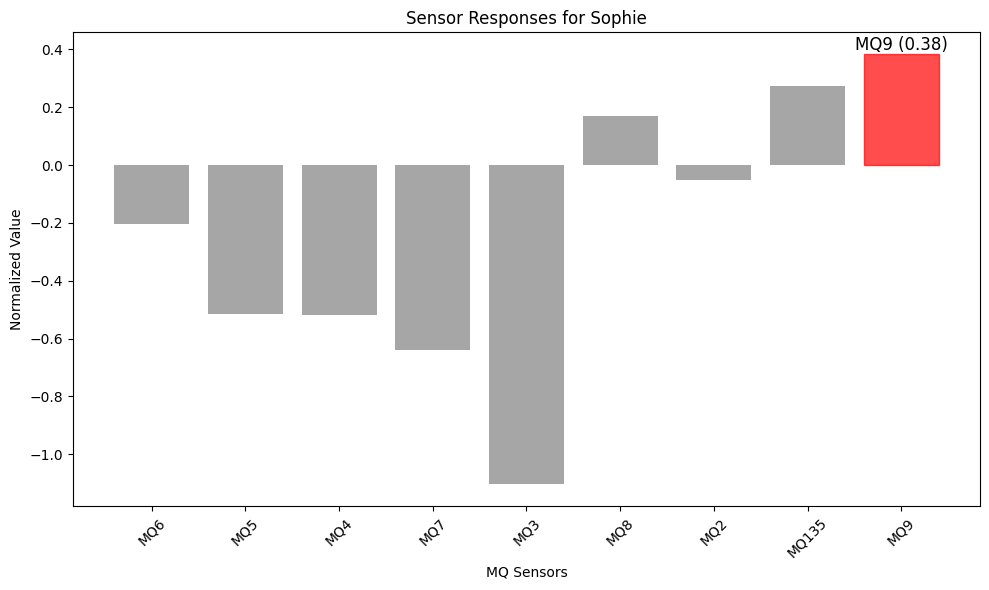

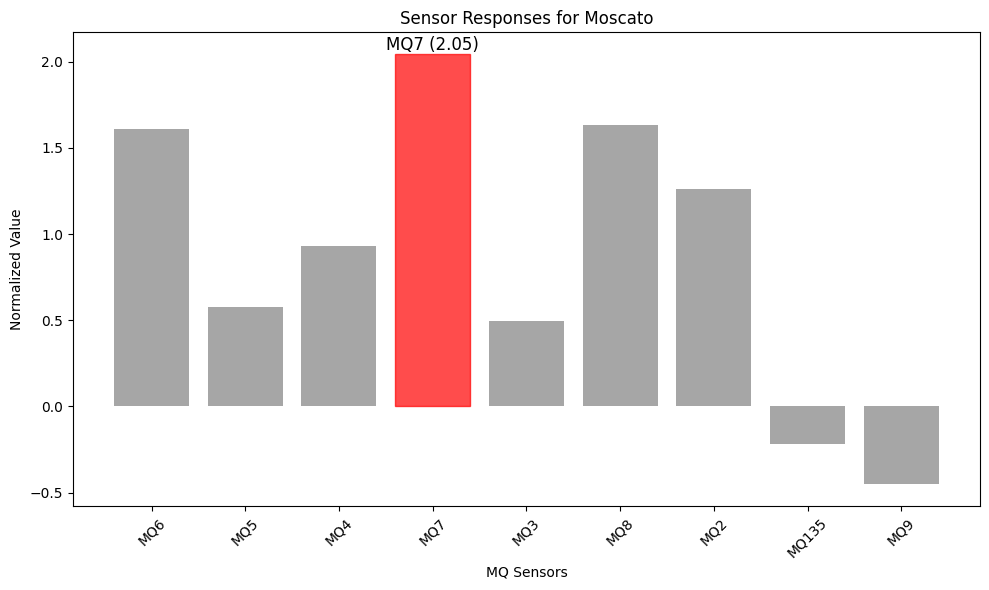

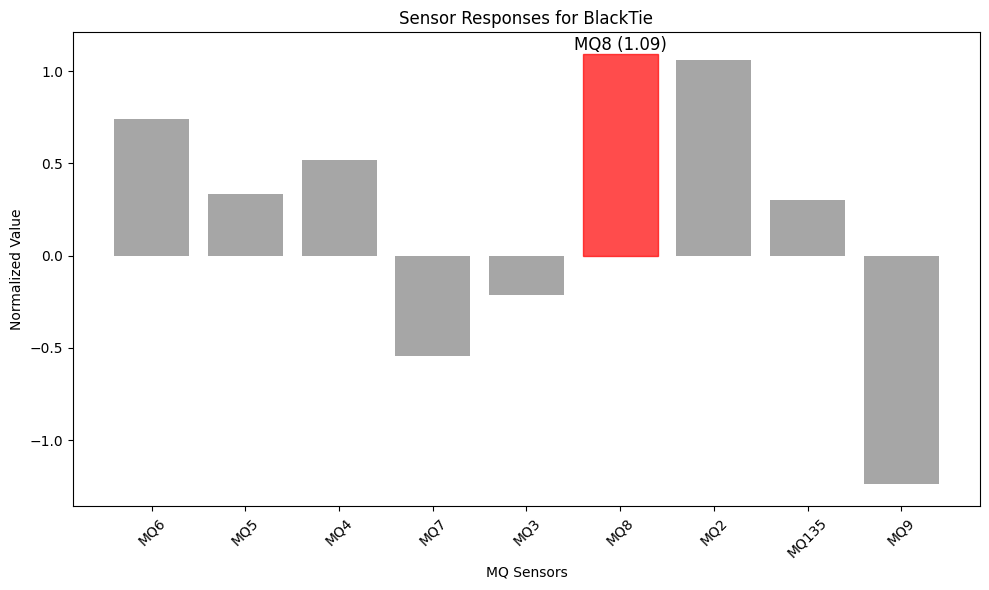

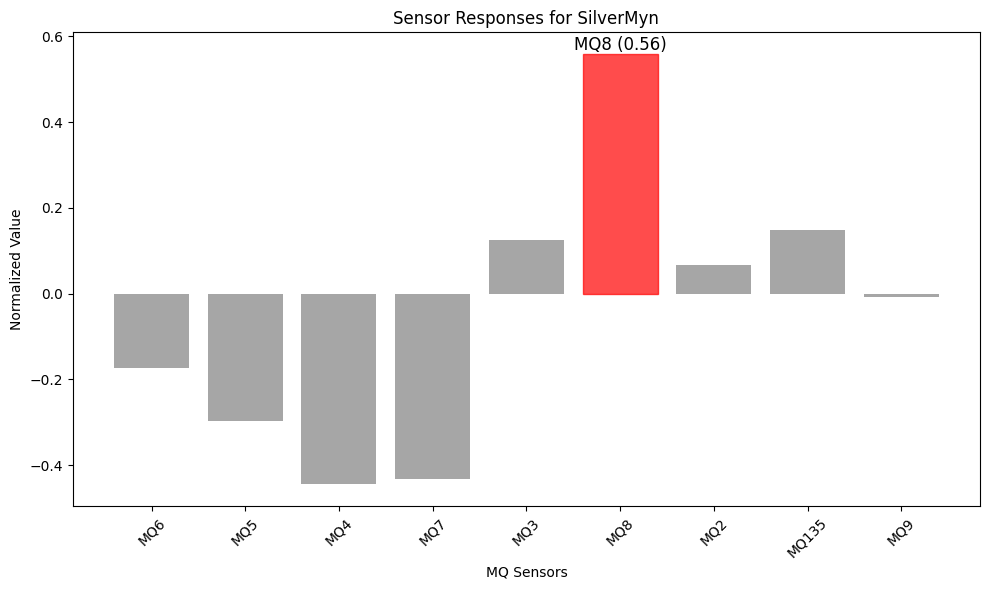

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the sensor values for each wine and mark the highest sensor
def plot_wine_sensor_values(df, mq_sensors, wine_labels, color_map):
    """
    Plots the sensor values for each wine and highlights the highest sensor.
    
    Parameters:
    df (DataFrame): Normalized data containing sensor data and wine labels.
    mq_sensors (list): List of MQ sensor columns.
    wine_labels (list): List of wine labels to plot.
    color_map (dict): Dictionary mapping wine labels to colors.
    """
    # Loop through each wine and create a plot
    for wine in wine_labels:
        wine_data = df[df['Target'] == wine][mq_sensors]
        
        # Calculate mean values for each sensor across all rows for the wine
        mean_values = wine_data.mean()
        
        # Find the highest sensor
        highest_sensor = mean_values.idxmax()
        
        # Create a bar plot for the wine
        plt.figure(figsize=(10, 6))
        bars = plt.bar(mean_values.index, mean_values.values, color='gray', alpha=0.7)

        # Highlight the highest sensor with a different color
        highest_index = mq_sensors.index(highest_sensor)
        bars[highest_index].set_color('red')

        # Add labels and title
        plt.xlabel('MQ Sensors')
        plt.ylabel('Normalized Value')
        plt.title(f'Sensor Responses for {wine}')
        plt.xticks(rotation=45)

        # Annotate the highest sensor value
        plt.text(highest_index, mean_values[highest_sensor], f'{highest_sensor} ({mean_values[highest_sensor]:.2f})', 
                 ha='center', va='bottom', fontsize=12, color='black')

        plt.tight_layout()
        plt.show()

# Example usage
wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]
mq_sensors = ["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]
color_map = {
    "TallHorse": "blue", 
    "Namaqua": "green", 
    "Sophie": "purple", 
    "Moscato": "orange", 
    "BlackTie": "red", 
    "SilverMyn": "brown"
}

# Call the function to plot sensor values for each wine
plot_wine_sensor_values(filtered_data_clean, mq_sensors, wine_labels, color_map)


In [170]:
import pandas as pd

# Function to create a styled table of sensor prevalence for each wine
def create_sensor_prevalence_table(df, mq_sensors, wine_labels):
    """
    Creates a table displaying the prevalence of each sensor for each wine.
    
    Parameters:
    df (DataFrame): Data containing sensor data and wine labels.
    mq_sensors (list): List of MQ sensor columns.
    wine_labels (list): List of wine labels to include in the table.
    
    Returns:
    styled_table (Styler): A styled DataFrame for display.
    """
    # Replace MQ sensor labels with gas names
    sensor_labels = {
        "MQ3": "Alcohol",
        "MQ4": "Methane",
        "MQ6": "Butane",
        "MQ7": "CO",
        "MQ8": "Hydrogen",
        "MQ9": "LPG, CO",
        "MQ135": "Ammonia"
    }
    
    # Prepare a list to store the results
    sensor_prevalence = []

    # Loop through each wine and calculate mean values for each sensor
    for wine in wine_labels:
        wine_data = df[df['Target'] == wine][mq_sensors]
        
        # Calculate mean values for each sensor across all rows for the wine
        mean_values = wine_data.abs().mean().to_dict()
        
        # Calculate total mean value for percentage calculation
        total_value = sum(mean_values.values())
        
        # Calculate percentages and handle division by zero
        percentages = {sensor: (mean / total_value * 100) if total_value > 0 else 0 for sensor, mean in mean_values.items()}
        
        # Store the result as a tuple
        sensor_prevalence.append((wine, *percentages.values()))

    # Create a DataFrame for easier representation
    prevalence_df = pd.DataFrame(sensor_prevalence, columns=['Wine'] + [sensor_labels[sensor] for sensor in mq_sensors])

    # Highlight the maximum value in each row
    def highlight_max(s):
        """Highlight the maximum value in each row."""
        is_max = s == s.max()
        return ['background-color: red; color: white; font-weight: bold;' if v else '' for v in is_max]

    # Apply styling and format the values to show 1 decimal place with a percentage sign
    styled_table = prevalence_df.style.apply(highlight_max, subset=prevalence_df.columns[1:], axis=1) \
                                     .set_table_styles({
                                         'Wine': [{'selector': 'th', 'props': 'font-size: 12px; font-weight: bold;'}],
                                         '': [{'selector': 'th', 'props': 'font-size: 12px; font-weight: bold;'}],  # Larger font size for all headers
                                         '': [{'selector': 'td', 'props': 'font-size: 12px; height: 30px;'}],  # Adjust font size and row height
                                         '': [{'selector': 'caption', 'props': 'font-size: 12px; font-weight: bold; text-align: center;'}]  # Adjust caption size
                                     }) \
                                     .set_caption('Most Prominent Gas Per Wine') \
                                     .set_properties(**{'font-size': '14pt'}) \
                                     .format({col: "{:.1f}%" for col in prevalence_df.columns[1:]})  # Format as percentage with 1 decimal place

    return styled_table

# Example usage
wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]
mq_sensors = ["MQ6", "MQ4", "MQ7", "MQ3", "MQ8", "MQ135", "MQ9"]

# Call the function to create the sensor prevalence table
styled_table = create_sensor_prevalence_table(filtered_data_clean, mq_sensors, wine_labels)

# Display the table (in Jupyter, it would display automatically)
styled_table


,Wine,Butane,Methane,CO,Alcohol,Hydrogen,Ammonia,"LPG, CO"
0,TallHorse,10.6%,12.9%,16.6%,14.7%,20.3%,18.1%,6.9%
1,Namaqua,13.3%,5.6%,10.3%,14.2%,27.9%,20.8%,7.9%
2,Sophie,8.0%,15.4%,19.3%,25.8%,7.3%,14.0%,10.1%
3,Moscato,19.5%,11.6%,24.7%,12.9%,19.7%,4.7%,6.9%
4,BlackTie,14.5%,9.9%,13.0%,7.6%,20.7%,7.6%,26.7%
5,SilverMyn,8.9%,15.5%,17.6%,15.8%,15.8%,17.4%,9.0%


In [32]:
# from sklearn.preprocessing import StandardScaler

# # Standardize the features (mean=0, variance=1)
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(features)

# # Create a new DataFrame with scaled features for further analysis
# scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
# scaled_data['Target'] = target_labels
# scaled_data['Day'] = day_labels

# scaled_data.head()  # Check the scaled data


,MQ6,MQ5,MQ4,MQ7,MQ3,MQ8,MQ2,MQ135,MQ9,BMPTemperature,Pressure(Pa),DHTTemperature,Humidity,Target,Day
0,0.340147,0.326440,0.510462,0.937327,-4.433567,0.839629,5.678840,3.875448,1.045740,3.320620,1.199601,-1.219483,0.349004,BlackTie,23rd
1,0.330054,0.369619,0.510462,0.937327,-4.263904,0.839629,5.678840,3.847206,1.129828,3.359788,1.014497,-1.219483,0.349004,BlackTie,23rd
2,0.330054,0.412799,0.478683,0.885918,-4.603231,0.839629,5.678840,3.847206,1.045740,3.398956,0.913853,-1.219483,0.349004,BlackTie,23rd
3,0.309867,0.369619,0.542240,0.963032,-4.433567,0.839629,5.810965,3.875448,1.213917,3.398956,0.619745,-1.219483,0.349004,BlackTie,23rd
4,0.330054,0.369619,0.478683,0.885918,-4.433567,0.839629,5.678840,3.847206,1.045740,3.398956,0.553127,-1.219483,0.349004,BlackTie,23rd


In [36]:
# from sklearn.linear_model import LinearRegression

# # Separate environmental features and gas sensor data
# env_features = filtered_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]]
# gas_sensors = filtered_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]]

# # Fit a linear regression model to predict sensor values based on environmental factors
# reg_model = LinearRegression()
# reg_model.fit(env_features, gas_sensors)

# # Predict the sensor values using environmental features
# predicted_sensors = reg_model.predict(env_features)

# # Subtract predicted values from actual sensor readings to remove environmental influence
# residual_sensors = gas_sensors - predicted_sensors

# # Create a new DataFrame with residuals and target labels
# residual_data = pd.DataFrame(residual_sensors, columns=gas_sensors.columns)
# residual_data['Target'] = target_labels
# residual_data['Day'] = day_labels

# residual_data.head()  # Check the residual data


,MQ6,MQ5,MQ4,MQ7,MQ3,MQ8,MQ2,MQ135,MQ9,Target,Day
0,108.176663,7.493150,15.880180,16.129944,-12.760260,75.661820,61.798441,59.644881,-4.697129,BlackTie,23rd
1,101.202238,7.884492,14.992106,15.259455,-11.611910,73.898103,61.426829,60.993506,-2.923671,BlackTie,23rd
2,98.016661,8.499462,13.436380,12.572896,-13.471425,73.038239,61.106948,61.958040,-3.567101,BlackTie,23rd
3,86.305174,6.720730,14.279059,14.932410,-12.444038,69.890790,62.926806,67.777802,-0.115391,BlackTie,23rd
4,86.105452,6.544342,12.016917,11.787335,-12.437834,69.177871,60.886002,67.869513,-1.786568,BlackTie,23rd


In [27]:
# import torch
# import torch.nn as nn

# # Define the autoencoder model
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(13, 8),
#             nn.ReLU(),
#             nn.Linear(8, 3)  # Reduce to 3-dimensional latent space
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(3, 8),
#             nn.ReLU(),
#             nn.Linear(8, 13)  # Reconstruct original feature set
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# # Initialize the model, loss function, and optimizer
# model = Autoencoder()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Prepare data for training (convert to torch tensors)
# features_tensor = torch.tensor(scaled_features, dtype=torch.float32)

# # Training loop
# for epoch in range(100):  # Example number of epochs
#     optimizer.zero_grad()
#     outputs = model(features_tensor)
#     loss = criterion(outputs, features_tensor)
#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print(f'Epoch {epoch}, Loss: {loss.item()}')

# # After training, extract the encoded features
# with torch.no_grad():
#     encoded_features = model.encoder(features_tensor).numpy()

# # Create a DataFrame with the encoded features
# encoded_data = pd.DataFrame(encoded_features, columns=['Latent1', 'Latent2', 'Latent3'])
# encoded_data['Target'] = target_labels
# encoded_data['Day'] = day_labels

# encoded_data.head()  # Check the encoded features


Epoch 0, Loss: 1.0495800971984863
Epoch 10, Loss: 1.0272074937820435
Epoch 20, Loss: 1.0093036890029907
Epoch 30, Loss: 0.9928930401802063
Epoch 40, Loss: 0.9747068285942078
Epoch 50, Loss: 0.953523576259613
Epoch 60, Loss: 0.9279383420944214
Epoch 70, Loss: 0.8975426554679871
Epoch 80, Loss: 0.8632144331932068
Epoch 90, Loss: 0.8271591663360596


,Latent1,Latent2,Latent3,Target,Day
0,0.123720,0.500623,-2.981549,BlackTie,23rd
1,0.135877,0.501115,-2.986837,BlackTie,23rd
2,0.090012,0.467404,-2.982333,BlackTie,23rd
3,0.107877,0.469976,-3.010742,BlackTie,23rd
4,0.064717,0.430512,-2.942872,BlackTie,23rd


In [34]:
# from sklearn.cluster import KMeans

# # Perform K-means clustering on the scaled features
# kmeans = KMeans(n_clusters=len(wine_labels), random_state=42)
# kmeans.fit(scaled_features)

# # Add the cluster labels to the DataFrame
# scaled_data['Cluster'] = kmeans.labels_

# # Visualize the clustering results
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='MQ6', y='MQ7', hue='Cluster', style='Day', data=scaled_data, palette='Set1')
# plt.title('K-Means Clustering of Wine Data')
# plt.show()


ValueError: Could not interpret value `Cluster` for `hue`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

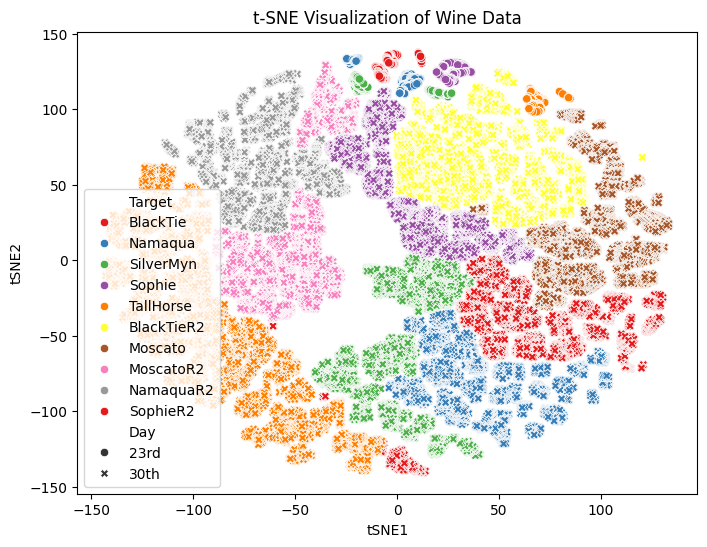

In [29]:
# from sklearn.manifold import TSNE

# # Perform t-SNE on the scaled features
# tsne = TSNE(n_components=2, random_state=42)
# tsne_result = tsne.fit_transform(scaled_features)

# # Create a DataFrame for the t-SNE results
# tsne_df = pd.DataFrame(tsne_result, columns=['tSNE1', 'tSNE2'])
# tsne_df['Target'] = target_labels
# tsne_df['Day'] = day_labels

# # Plot the t-SNE result
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='tSNE1', y='tSNE2', hue='Target', style='Day', data=tsne_df, palette='Set1')
# plt.title('t-SNE Visualization of Wine Data')
# plt.show()


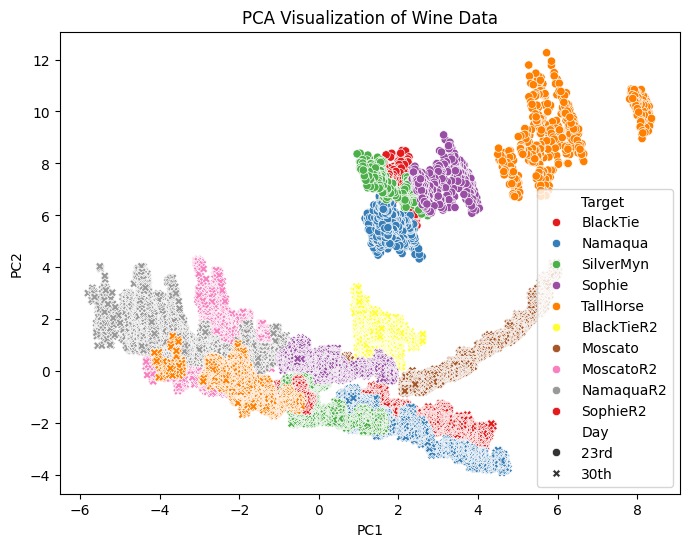

In [30]:
# from sklearn.decomposition import PCA

# # Perform PCA on scaled features
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(scaled_features)

# # Create a DataFrame for PCA results
# pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
# pca_df['Target'] = target_labels
# pca_df['Day'] = day_labels

# # Plot the PCA result
# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='PC1', y='PC2', hue='Target', style='Day', data=pca_df, palette='Set1')
# plt.title('PCA Visualization of Wine Data')
# plt.show()


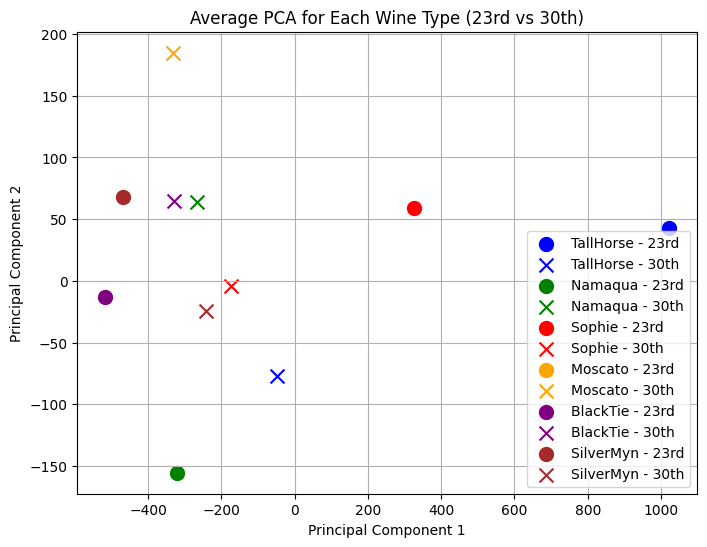

In [35]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Define wine labels
# wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]

# # Define color map for the wines
# color_map = {
#     "TallHorse": 'blue',
#     "Namaqua": 'green',
#     "Sophie": 'red',
#     "Moscato": 'orange',
#     "BlackTie": 'purple',
#     "SilverMyn": 'brown'
# }

# # Define marker styles for different days
# marker_map = {
#     '23rd': 'o',  # Circle for 23rd
#     '30th': 'x'   # X for 30th
# }

# # Function to process each dataset, perform PCA, and calculate average PCA values
# def process_data_for_pca(data, day_label):
#     # Filter for specific wine names in the Target column
#     filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]

#     # Separate features (MQ and environmental data) from the Target and Day columns
#     features = filtered_data.drop(columns=['Target', 'Day'])
#     target_labels = filtered_data['Target']

#     # Perform PCA with 2 components
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(features)

#     # Create a DataFrame for PCA results
#     pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     pca_df['Target'] = target_labels
#     pca_df['Day'] = day_label  # Add the day label

#     # Ensure the PCA components are numeric before applying mean
#     pca_df[['PC1', 'PC2']] = pca_df[['PC1', 'PC2']].apply(pd.to_numeric)

#     # Group by wine type and calculate the average of the PCA components
#     mean_pca = pca_df.groupby('Target', as_index=False)[['PC1', 'PC2']].mean()
    
#     return mean_pca

# # Perform PCA on both datasets
# mean_pca_23rd = process_data_for_pca(data_23rd, '23rd')
# mean_pca_30th = process_data_for_pca(data_30th, '30th')

# # Combine both datasets for plotting
# combined_mean_pca = pd.concat([mean_pca_23rd, mean_pca_30th])

# # Plotting the average PCA values for each wine type from both datasets
# plt.figure(figsize=(8, 6))

# # Scatter plot for both days with different markers but same colors for the same wine
# for wine in wine_labels:
#     # Plot data for 23rd
#     avg_pca_values_23rd = mean_pca_23rd[mean_pca_23rd['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
#         label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
#     )

#     # Plot data for 30th
#     avg_pca_values_30th = mean_pca_30th[mean_pca_30th['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
#         label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
#     )

# # Add labels and title
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()


In [38]:
# # Function to fit a linear regression model and obtain residuals
# def calculate_residuals(data):
#     # Filter for specific wine names in the Target column
#     filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]

#     # Separate environmental features and gas sensor data
#     env_features = filtered_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]]
#     gas_sensors = filtered_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]]

#     # Fit a linear regression model to predict sensor values based on environmental factors
#     reg_model = LinearRegression()
#     reg_model.fit(env_features, gas_sensors)

#     # Predict the sensor values using environmental features
#     predicted_sensors = reg_model.predict(env_features)

#     # Subtract predicted values from actual sensor readings to remove environmental influence
#     residual_sensors = gas_sensors - predicted_sensors

#     # Create a new DataFrame with residuals and target labels
#     residual_data = pd.DataFrame(residual_sensors, columns=gas_sensors.columns)
#     residual_data['Target'] = filtered_data['Target'].values
#     residual_data['Day'] = filtered_data['Day'].values
    
#     return residual_data

# # Calculate residuals for both datasets
# residual_data_23rd = calculate_residuals(data_23rd)
# residual_data_30th = calculate_residuals(data_30th)


In [39]:

# # Function to process residual data, perform PCA, and calculate average PCA values
# def process_data_for_pca(residual_data, day_label):
#     # Separate features from the Target and Day columns
#     features = residual_data.drop(columns=['Target', 'Day'])
#     target_labels = residual_data['Target']

#     # Perform PCA with 2 components
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(features)

#     # Create a DataFrame for PCA results
#     pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     pca_df['Target'] = target_labels
#     pca_df['Day'] = day_label  # Add the day label

#     # Group by wine type and calculate the average of the PCA components
#     mean_pca = pca_df.groupby('Target', as_index=False)[['PC1', 'PC2']].mean()
    
#     return mean_pca

# # Perform PCA on both datasets
# mean_pca_23rd = process_data_for_pca(residual_data_23rd, '23rd')
# mean_pca_30th = process_data_for_pca(residual_data_30th, '30th')


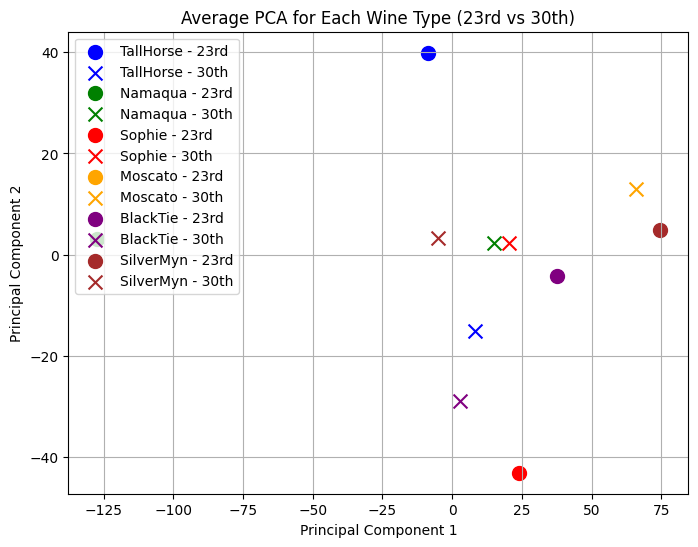

In [40]:
# # Define color map for the wines
# color_map = {
#     "TallHorse": 'blue',
#     "Namaqua": 'green',
#     "Sophie": 'red',
#     "Moscato": 'orange',
#     "BlackTie": 'purple',
#     "SilverMyn": 'brown'
# }

# # Define marker styles for different days
# marker_map = {
#     '23rd': 'o',  # Circle for 23rd
#     '30th': 'x'   # X for 30th
# }

# # Combine both datasets for plotting
# combined_mean_pca = pd.concat([mean_pca_23rd, mean_pca_30th])

# # Plotting the average PCA values for each wine type from both datasets
# plt.figure(figsize=(8, 6))

# # Scatter plot for both days with different markers but same colors for the same wine
# for wine in wine_labels:
#     # Plot data for 23rd
#     avg_pca_values_23rd = mean_pca_23rd[mean_pca_23rd['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
#         label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
#     )

#     # Plot data for 30th
#     avg_pca_values_30th = mean_pca_30th[mean_pca_30th['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
#         label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
#     )

# # Add labels and title
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()


In [46]:
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Define features (environmental) and target (MQ sensor residuals)
# X = combined_data[["BMPTemperature", "Pressure(Pa)", "DHTTemperature", "Humidity"]].values
# y = combined_data[["MQ6", "MQ5", "MQ4", "MQ7", "MQ3", "MQ8", "MQ2", "MQ135", "MQ9"]].values

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Convert to PyTorch tensors
# X_train_tensor = torch.FloatTensor(X_train)
# y_train_tensor = torch.FloatTensor(y_train)
# X_test_tensor = torch.FloatTensor(X_test)
# y_test_tensor = torch.FloatTensor(y_test)

# # Define the neural network architecture
# class NeuralNetwork(nn.Module):
#     def __init__(self):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(4, 64)  # Input layer
#         self.fc2 = nn.Linear(64, 64)  # Hidden layer
#         self.fc3 = nn.Linear(64, 9)   # Output layer (MQ sensor outputs)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))  # Activation function
#         x = torch.relu(self.fc2(x))  # Activation function
#         x = self.fc3(x)               # Output layer
#         return x

# # Instantiate the model, define the loss function and the optimizer
# model = NeuralNetwork()
# criterion = nn.MSELoss()  # Mean Squared Error Loss
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training the model
# num_epochs = 100
# for epoch in range(num_epochs):
#     model.train()
    
#     # Forward pass
#     outputs = model(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Evaluating the model
# model.eval()
# with torch.no_grad():
#     predicted_sensors = model(X_test_tensor)

# # Calculate residuals
# residuals = predicted_sensors.numpy() - y_test_tensor.numpy()

# # Calculate distances between predicted and actual
# distances = np.linalg.norm(residuals, axis=1)

# # Calculate maximum distances for normalization
# max_distances = np.linalg.norm(y_test_tensor.numpy(), axis=1)

# # Calculate total distance over max distance for all wines
# total_distance = np.sum(distances)
# total_max_distance = np.sum(max_distances)

# error_ratio = total_distance / total_max_distance if total_max_distance > 0 else 0

# print(f'Total Distance: {total_distance:.4f}')
# print(f'Total Max Distance: {total_max_distance:.4f}')
# print(f'Error Ratio (Total Distance / Total Max Distance): {error_ratio:.4f}')


Epoch [10/100], Loss: 454494.4062
Epoch [20/100], Loss: 454099.1875
Epoch [30/100], Loss: 453693.5625
Epoch [40/100], Loss: 453253.1250
Epoch [50/100], Loss: 452772.5312
Epoch [60/100], Loss: 452247.2812
Epoch [70/100], Loss: 451679.7188
Epoch [80/100], Loss: 451070.5938
Epoch [90/100], Loss: 450420.0625
Epoch [100/100], Loss: 449725.6562
Total Distance: 52939380.0000
Total Max Distance: 53224828.0000
Error Ratio (Total Distance / Total Max Distance): 0.9946


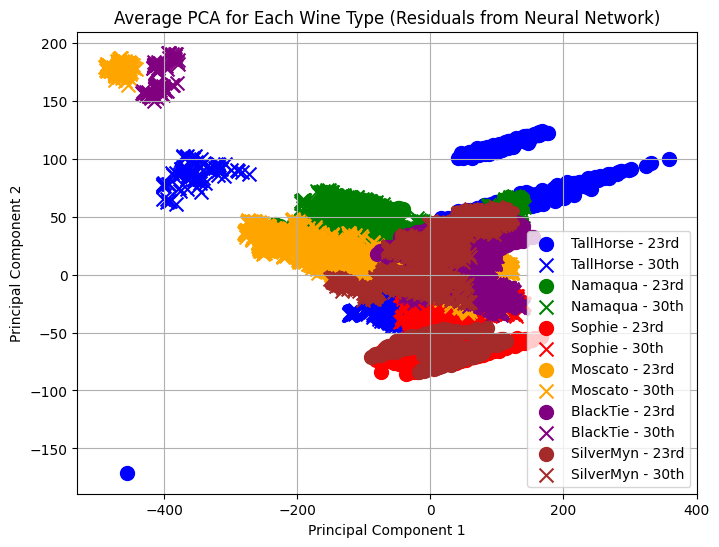

In [44]:
# # Assuming you have the following imports and previous steps:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Define wine labels and color map as before
# wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]
# color_map = {
#     "TallHorse": 'blue',
#     "Namaqua": 'green',
#     "Sophie": 'red',
#     "Moscato": 'orange',
#     "BlackTie": 'purple',
#     "SilverMyn": 'brown'
# }

# # Define marker styles for different days
# marker_map = {
#     '23rd': 'o',  # Circle for 23rd
#     '30th': 'x'   # X for 30th
# }

# # Function to perform PCA on residual data
# def perform_pca_on_residuals(data, day_label):
#     # Filter for specific wine names in the Target column
#     filtered_data = data[data['Target'].str.contains('|'.join(wine_labels))]
    
#     # Separate features (residuals) from the Target and Day columns
#     features = filtered_data.drop(columns=['Target', 'Day'])
#     target_labels = filtered_data['Target']

#     # Perform PCA with 2 components
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(features)

#     # Create a DataFrame for PCA results
#     pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     pca_df['Target'] = target_labels
#     pca_df['Day'] = day_label  # Add the day label

#     return pca_df

# # Perform PCA on the residuals for both datasets
# pca_residuals_23rd = perform_pca_on_residuals(residual_data[residual_data['Day'] == '23rd'], '23rd')
# pca_residuals_30th = perform_pca_on_residuals(residual_data[residual_data['Day'] == '30th'], '30th')

# # Combine both datasets for plotting
# combined_pca_residuals = pd.concat([pca_residuals_23rd, pca_residuals_30th])

# # Plotting the average PCA values for each wine type from both datasets
# plt.figure(figsize=(8, 6))

# # Scatter plot for both days with different markers but same colors for the same wine
# for wine in wine_labels:
#     # Plot data for 23rd
#     avg_pca_values_23rd = pca_residuals_23rd[pca_residuals_23rd['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
#         label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
#     )

#     # Plot data for 30th
#     avg_pca_values_30th = pca_residuals_30th[pca_residuals_30th['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
#         label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
#     )

# # Add labels and title
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Average PCA for Each Wine Type (Residuals from Neural Network)')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()


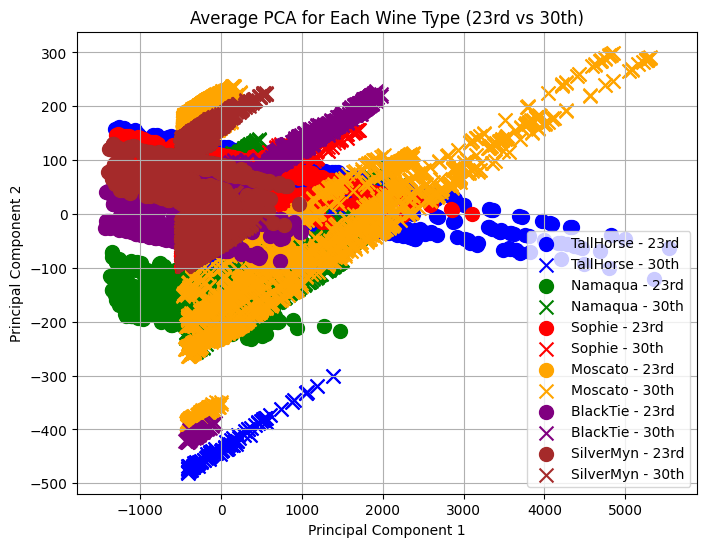

In [45]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # Assuming combined_data is your original DataFrame containing the necessary data

# # Define the color map for the wines
# color_map = {
#     "TallHorse": 'blue',
#     "Namaqua": 'green',
#     "Sophie": 'red',
#     "Moscato": 'orange',
#     "BlackTie": 'purple',
#     "SilverMyn": 'brown'
# }

# # Define marker styles for different days
# marker_map = {
#     '23rd': 'o',  # Circle for 23rd
#     '30th': 'x'   # X for 30th
# }

# # Function to perform PCA on given data for a specific day
# def perform_pca(data, day_label):
#     # Filter data for the specific day
#     filtered_data = data[data['Day'] == day_label]
#     features = filtered_data.drop(columns=['Target', 'Day'])
    
#     # Perform PCA
#     pca = PCA(n_components=2)
#     pca_result = pca.fit_transform(features)

#     # Create a DataFrame for PCA results
#     pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
#     pca_df['Target'] = filtered_data['Target']
#     pca_df['Day'] = day_label  # Add the day label

#     return pca_df

# # Perform PCA on the combined data for both datasets
# pca_23rd = perform_pca(combined_data, '23rd')
# pca_30th = perform_pca(combined_data, '30th')

# # Combine both datasets for plotting
# combined_mean_pca = pd.concat([pca_23rd, pca_30th])

# # Define wine labels for plotting
# wine_labels = ["TallHorse", "Namaqua", "Sophie", "Moscato", "BlackTie", "SilverMyn"]

# # Plotting the average PCA values for each wine type from both datasets
# plt.figure(figsize=(8, 6))

# # Scatter plot for both days with different markers but same colors for the same wine
# for wine in wine_labels:
#     # Plot data for 23rd
#     avg_pca_values_23rd = pca_23rd[pca_23rd['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_23rd['PC1'], avg_pca_values_23rd['PC2'], 
#         label=f'{wine} - 23rd', color=color_map[wine], marker=marker_map['23rd'], s=100
#     )

#     # Plot data for 30th
#     avg_pca_values_30th = pca_30th[pca_30th['Target'] == wine]
#     plt.scatter(
#         avg_pca_values_30th['PC1'], avg_pca_values_30th['PC2'], 
#         label=f'{wine} - 30th', color=color_map[wine], marker=marker_map['30th'], s=100
#     )

# # Add labels and title
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('Average PCA for Each Wine Type (23rd vs 30th)')
# plt.legend(loc='best')
# plt.grid(True)

# # Show the plot
# plt.show()
